# Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras import layers
from keras.utils import normalize
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
%cd '/content/drive/MyDrive/Cacao_BDA/db_b'
!ls

/content/drive/MyDrive/Cacao_BDA/db_b
Monilia  Sana


# Carga y analisis de dataset

In [7]:
#obtener directorio de db
fpath = '/content/drive/MyDrive/Cacao_BDA/db_b'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Sana', 'Monilia'] 

No. of categories =  2


In [8]:
#cargar imagenes y etiquetas
def load_images_and_labels(categories):
    img_lst=[]
    img_names=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (312, 416))
            img_array = Image.fromarray(img, 'RGB')
    
            img_lst.append(np.array(img_array)) 
            img_names.append(image_name)       
            labels.append(index)
    return img_lst, img_names, labels

images, name_images, labels = load_images_and_labels(categories)
print("Nro. de imagenes cargadas = ",len(images), "\nNro. de nombre imagenes cargadas = ",len(name_images), "\nNro. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))
     

Nro. de imagenes cargadas =  438 
Nro. de nombre imagenes cargadas =  438 
Nro. de etiquetas cargadas =  438
<class 'list'> <class 'list'>


# Preparar imagenes

In [9]:
#crear matriz de imagenes con sus etiquetas
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (438, 416, 312, 3) 
Labels shape =  (438,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
#funcion para mostrar imagenes
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Cacao : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

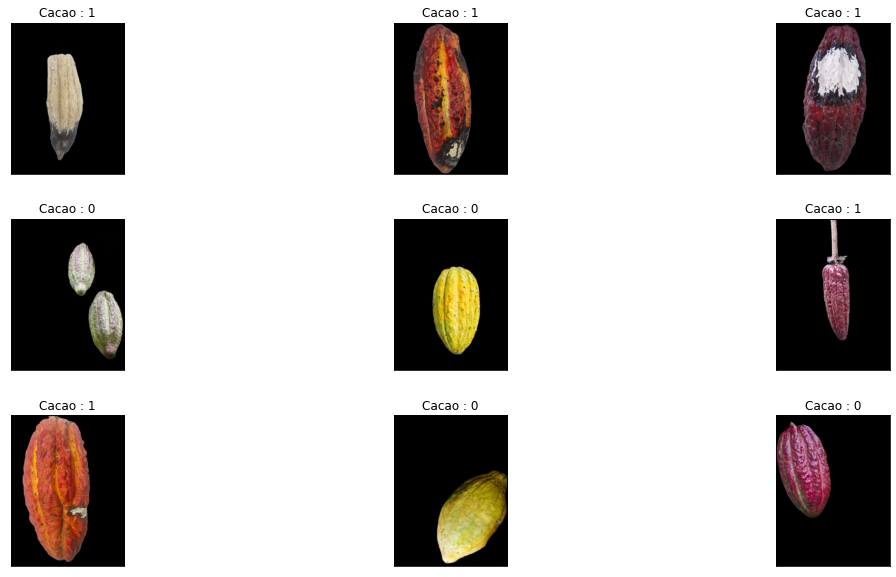

In [11]:
#mostrar imagenes
display_rand_images(images, labels)

In [ ]:
#normalizar contenido de listas
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

# Division de datos de entrenamiento, prueba y validación

In [20]:
#dividir datos de prueba
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(images, labels):
  print("TRAIN:", train_index, "TEST:", test_index,"\n")
  x_train, x_test = images[train_index], images[test_index]
  y_train, y_test = labels[train_index], labels[test_index]

TRAIN: [112 309 244 330 381 179  70 167  74 148 434 318 391 104   3 195  35 348
 241 303 321 325 310 401 108  47 302  89  87 409 278 336 199  27 222 127
 387 102 365  62 176 424   5 119 147  67 225 423  18 326 398  10 317 159
 254 316 255 237 117  48 245 437 431 435 297 275 380 308  65 197 285  12
 346 341 177 342 116 164 201 132  58 350  85 349  29  26 154 200 118 226
 220 419 182  56 151 383 322 335 320 106   0 432  77  81 403 315  54 370
 415 402  40 280 368 123 361   6 100 189  21  46 421 293 300 113 428 327
 126  90  59 180 242  91 360 232 259 114 150 202 420 276 425 277  39   9
 248 294 260  11 173 328  28 354 314 433  73  13  55  82 165 246  53 252
 295 208 221 290  43 120 337 239  45 205 359  15  52 153 262 351  51  34
 373 187 307 209  75 124 125 312 264 279 269 374 353 392 233 184 339 356
 152 301 236 367 213  93 389 265 217 155 250 174 247  92 296 404 214 338
 411 224 272 163 122 426 299 230   2  64  97 109  98 358 169 161 145 168
 288 193 143  95 240 186  76 344 170 194 355

In [21]:
#dividir datos de validacion
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)
for train_index, val_index in sss.split(x_train, y_train):
  print("TRAIN:", train_index, "TEST:", val_index)
  xf_train, x_val = x_train[train_index], x_train[val_index]
  yf_train, y_val = y_train[train_index], y_train[val_index]

TRAIN: [121  64 310 173 127 344 331 102 196 325 349 185 179 147 210  20 272 131
 304 228  34 116 200 105  79 288 321 338 340 343 224 134  85 183  49 291
  41 332 100  62 275 266 217 206 171 129 214 174 187 342  18 268  97 154
   8 138  83  86  91 230 122 112 162 285 337  38 104 281 203 117 159 176
 324  67  75 241 284 184   1  36 106 238 320 339 297 124 235 308 153  89
 273  17 265 139 192 335  80   9 309  22 177 326 142 317 221 189  76 261
  24 155 193 182  43  55 208  46  13 345  69 111 211 218 248 327   0 263
 216  59  48 307 233 212 170  57  84  78  96   5   7 188 150 336  77 114
  61 315  50 243 245  33  28 169 250 130 286  27 232 199 257  72 209  82
 181 215 220 108 110   3 300 227  58  29  54 198  88 143  52 316 113 231
 219 322 167   4 348  16 329 135 115 255  39 244 289 258 301  81 205 269
 242  19 292  21 191 249 133 166 283 180  53 293 226 144  14 312 103  25
 165 148  12 290 163 302 271 295 303 314 195 213 251  15   6 252  56  92
 160 259 256 158  90 311  63 323  37 234  65

In [57]:
#comprobar forma de los datos de entrenamiento, prueba y validacion
print("x_train shape = ",xf_train.shape)
print("y_train shape = ",yf_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (280, 416, 312, 3)
y_train shape =  (280,)

x_test shape =  (88, 416, 312, 3)
y_test shape =  (88,)

x_val shape =  (70, 416, 312, 3)
y_val shape =  (70,)


In [22]:
#escalamiento de datos
xf_train = normalize(xf_train, axis=1)
x_test = normalize(x_test, axis=1)
x_val = normalize(x_val, axis=1)

# Modelo MobilNet

In [ ]:
#instanciar modelo 
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=xf_train[0].shape, include_top=False, weights="imagenet")
#desactivar el entrenamiento por defecto en cada capa
for layer in pre_trained_model.layers:
  layer.trainable = False

#obtener capas
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output
#agregar capas de finales
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

#instancia completa del modelo
model2 = tf.keras.Model(pre_trained_model.input, x)

#compilar modelo
model2.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [33]:
#analizar optimizador modelo 
model2.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [26]:
#regularizar modelo
es = EarlyStopping(monitor="val_accuracy", mode="min", patience=10, verbose=1)

In [27]:
steps_per_epoch = (xf_train.shape[0]//32)
validation_steps = (x_val.shape[0]// 32)

In [49]:
model2.save('modelMobil_2_2023.h5')

# Entrenamiento

In [34]:
history2 = model2.fit(xf_train, yf_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 30,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = 32,
    callbacks=[es],
    verbose=1)

Epoch 1/30
8/8 [==============================] - 32s 4s/step - loss: 8.6526 - accuracy: 0.5391 - val_loss: 2.4553 - val_accuracy: 0.5000
Epoch 2/30
8/8 [==============================] - 30s 4s/step - loss: 2.2358 - accuracy: 0.5323 - val_loss: 0.5099 - val_accuracy: 0.6562
Epoch 3/30
8/8 [==============================] - 26s 3s/step - loss: 0.8216 - accuracy: 0.6734 - val_loss: 0.8714 - val_accuracy: 0.5938
Epoch 4/30
8/8 [==============================] - 27s 3s/step - loss: 0.8768 - accuracy: 0.6492 - val_loss: 0.4005 - val_accuracy: 0.7812
Epoch 5/30
8/8 [==============================] - 26s 3s/step - loss: 0.4327 - accuracy: 0.8306 - val_loss: 0.4700 - val_accuracy: 0.7812
Epoch 6/30
8/8 [==============================] - 26s 3s/step - loss: 0.3071 - accuracy: 0.8629 - val_loss: 0.3007 - val_accuracy: 0.8906
Epoch 7/30
8/8 [==============================] - 29s 3s/step - loss: 0.2045 - accuracy: 0.9073 - val_loss: 0.2671 - val_accuracy: 0.8750
Epoch 8/30
8/8 [==================

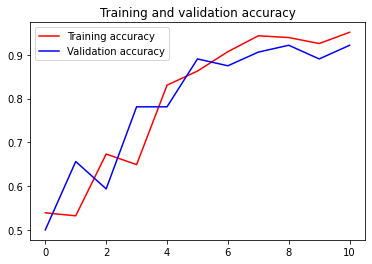

In [36]:
accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_2.png')
plt.show()

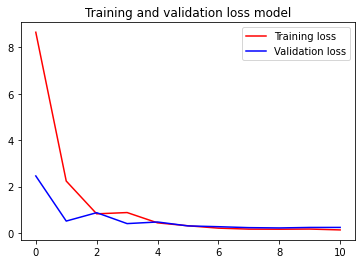

In [37]:
accuracy = history2.history['loss']
validation_accuracy = history2.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training loss')
plt.plot(epochs, validation_accuracy, 'b', label='Validation loss')
plt.title('Training and validation loss model')
plt.legend()
plt.savefig('loss_2.png')
plt.show()

In [35]:
model2.evaluate(x_test,y_test,batch_size=32)

3/3 [==============================] - 8s 2s/step - loss: 0.1961 - accuracy: 0.9318


[0.19608980417251587, 0.9318181872367859]

In [50]:
#realizar predicciones
y_pred = model2.predict(x_test,batch_size=32,verbose=0).astype(int)

In [52]:
#encontrar metricas de evaluacion
accuracy = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred, average='weighted')*100
recall = recall_score(y_test, y_pred, average='weighted')*100
f1 = f1_score(y_test, y_pred, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 90.91
F1 score: 90.87
Precision: 91.68
Recall: 90.91


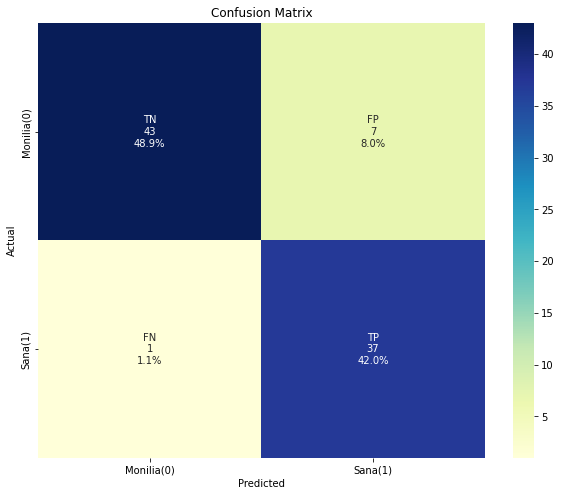

In [53]:
#obtener valores de la matriz 
cm= confusion_matrix(y_pred, y_test)
plt.figure(figsize = (10,8))

classes = ["TN","FP","FN","TP"]
values = ["{0:0.0f}".format(x) for x in cm.flatten()]

# calcular y obtener valores
percentages = ["{0:.1%}".format(x) for x in cm.flatten()/np.sum(cm)]
combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
combined = np.asarray(combined).reshape(2,2)

# crear matriz
b = sns.heatmap(cm, annot=combined, fmt="", cmap='YlGnBu')
#etiquetas
b.set_xticklabels(['Monilia(0)','Sana(1)'],fontsize=10)
b.set_yticklabels(['Monilia(0)','Sana(1)'],fontsize=10)
b.set(title='Confusion Matrix')
b.set(xlabel='Predicted', ylabel='Actual',)
plt.savefig('matrizconfusion_mobiln.png')
plt.show()

In [54]:
#metricas de evaluacion 2  (verificacion de clases)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91        50
           1       0.84      0.97      0.90        38

    accuracy                           0.91        88
   macro avg       0.91      0.92      0.91        88
weighted avg       0.92      0.91      0.91        88



In [55]:
"""CURVA ROC"""
#realizar predicciones del conjunto de prueba
y_predsroc = model2.predict(x_test).ravel()     

3/3 [==============================] - 8s 3s/step


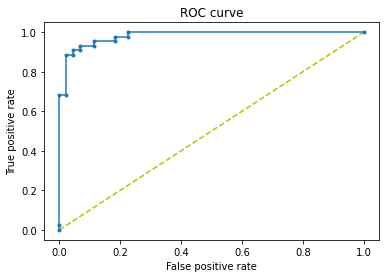

In [56]:
#obtener fp, tp y valor umbral
fp, tp, thresholds = roc_curve(y_test, y_predsroc)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fp, tp, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('roc_mobilnet.png')
plt.show()

In [48]:
for valum in thresholds:
  print(valum*100)

99.818432
95.18075
94.577551
51.70711300000001
41.371873
39.513627
32.45185
25.752488
22.564197999999998
21.262497
14.463446
12.889932000000002
8.5504524
5.5659719
0.0011663633999999998
